In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # hack, but works
import pandas as pd

from Dragonfly44_SFH.utils import plotting
from figure_style import *
from Dragonfly44_SFH.utils.styles import *

In [2]:
path_data = path_base+ "Dragonfly44_SFH/data/"
file_data = path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5"
path_data_UM = path_data+'UniverseMachine/'

In [3]:
# figure style 

color_Mhalo11 = '0.5'
color_Mhalo12 = 'orange'
color_Mhalo13 = 'b'
color_Mhalo14 = 'lime'

## extract figure elements from Behroozi+2018, fig 18, top-right

https://arxiv.org/pdf/1806.07893.pdf

_Long story short: It was easier to trace the subplot from Fig 18 directly (with coordinated saved to a file) than it was to try and reproduce it exactly from files provided in the Universe Machine release.
If you can provide code to reproduce this figure from the Universe Machine data release, please let me know._


Figure caption:

Figure 18. 
Top left: **total (including mergers) star formation histories for haloes in bins of Mpeak for our best-fitting model; coloured regions indicate the 16th −84th percentile range among different haloes in the best-fitting model.** 
**Top right: same, with main progenitor stellar mass histories.**
Middle left: same, with main progenitor SSFR histories. Middle right: same, with main progenitor intrahalo light (IHL) histories. 
Bottom left: same, with main progenitor $M_\ast/M_{peak}$ ratio histories. 
Bottom right: same, with main progenitor IHL / $M_\ast$ ratio histories. 
For all panels, bin widths are $\pm 0.25$ dex; e.g., the label $M_h = 10^{11}~M_\odot$ corresponds to $10.75 < \log_{10}(M_{peak}/ M_\odot) < 11.25$. Notes: Quiescent SSFRs in our models are fixed to $10^{−11.8} \mathrm{yr}^{−1}$ (sec. 3.2), explaining why massive haloes’ SSFRs are close to this value at low redshifts.




In [4]:
# fig 8 top-right subplot coordinates saved to file. 
# Extracted plotted coordinates directly via the figure from the XML data of fig 18 in the arxiv file
# Axis coordinates and labels are saved
# To convert from "pixels" (figure coordinates) to physical coordinates, 
# see the linear interpolation functions

import pickle
with open( path_data_UM+'behroozi2018_figure18_data.pkl','rb') as of:
    dict_coords = pickle.load( of )
    
dict_coords['Mhalo_11']['color'] = color_Mhalo11
dict_coords['Mhalo_12']['color'] = color_Mhalo12
dict_coords['Mhalo_13']['color'] = color_Mhalo13
dict_coords['Mhalo_14']['color'] = color_Mhalo14

dict_coords['Mhalo_11']['label'] = r'$\mathrm{M}_\mathrm{halo} = 10^{11}\,\mathrm{M}_\odot$'
dict_coords['Mhalo_12']['label'] = r'$\mathrm{M}_\mathrm{halo} = 10^{12}\,\mathrm{M}_\odot$'
dict_coords['Mhalo_13']['label'] = r'$\mathrm{M}_\mathrm{halo} = 10^{13}\,\mathrm{M}_\odot$'
dict_coords['Mhalo_14']['label'] = r'$\mathrm{M}_\mathrm{halo} = 10^{14}\,\mathrm{M}_\odot$'



In [5]:
from scipy.interpolate import interp1d

xs = [ dict_coords['fig_scale']['x'][k] for k in ['pix','redshift'] ]
f_x_zred_to_pix = interp1d( *xs[::-1], bounds_error=False, fill_value="extrapolate" )
f_x_pix_to_zred = interp1d( *xs, bounds_error=False, fill_value="extrapolate" )

ys = [ dict_coords['fig_scale']['y'][k] for k in ['pix','logmass'] ]
f_y_pix_to_logM = interp1d( *ys, bounds_error=False, fill_value="extrapolate" )

def transform_axes( x_pix, y_pix ):
    return f_x_pix_to_zred(x_pix), f_y_pix_to_logM(y_pix)

In [6]:
params_50 = dict( ls='--', lw=1., zorder=2 )
params_16_84 = dict( alpha=0.2, lw=0, zorder=1 )

def plot_fig18( Mhalo_keys, b18xscale=False, ax=None, xlim = [0,10] ):

    # plot 

    if ax is None: fig,ax = plt.subplots(1,1,figsize=(6,6))

    for Mhalo_key in Mhalo_keys:

        d = dict_coords[Mhalo_key]
        color = d['color']

        x1,y1 = [ d['q16'][k] for k in ['zred','logmass'] ]
        x2,y2 = [ d['q84'][k] for k in ['zred','logmass'] ]

        # interpolate to make same gridding
        xmins = [ np.min(x1), np.min(x2) ]
        xmaxs = [ np.max(x1), np.max(x2) ]
        xi = np.linspace( np.max(xmins)*1.0001, np.min(xmaxs)*0.9999, 50 )
        yi1 = interp1d( x1, y1 )(xi)
        yi2 = interp1d( x2, y2 )(xi)
        if b18xscale: xi = f_x_zred_to_pix( xi )

        ax.fill_between( xi, yi1,yi2, 
                         color=color, 
                        label=d['label'], 
                        **params_16_84 )

        x,y = [ d['q50'][k] for k in ['zred','logmass'] ]
        xi = np.linspace( np.min(x)*1.0001, np.max(x)*0.9999, 50 )
        yi = interp1d( x, y )(xi)
        if b18xscale: xi = f_x_zred_to_pix( xi )
        
        ax.plot( xi, yi, 
                 color=color, **params_50 )

    ax.set( xlabel='Redshift', ylabel=r'log( Stellar mass history  (M$_\odot$) )', yscale='linear' )

    ax.set_yticks( np.arange(6,13,1) )
    ax.set_ylim(6.1,12)
    
    xticks = [0,0.5]+np.arange(1,11,1).tolist()
    
    if b18xscale:
        xticks_scaled = f_x_zred_to_pix( xticks )
        ax.set_xticks( xticks_scaled )
        ax.set_xticklabels( xticks )

        xlim_scaled = f_x_zred_to_pix( xlim )
        ax.set_xlim( xlim_scaled )
        
    else:
        ax.set_xlim( xlim )
        ax.set_xticks( xticks )

    return ax


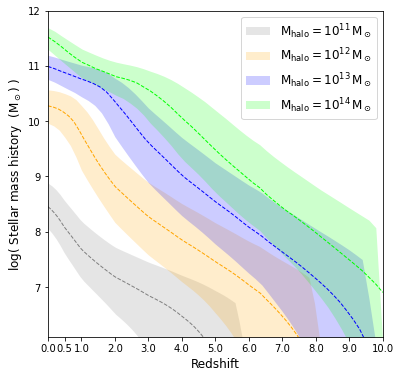

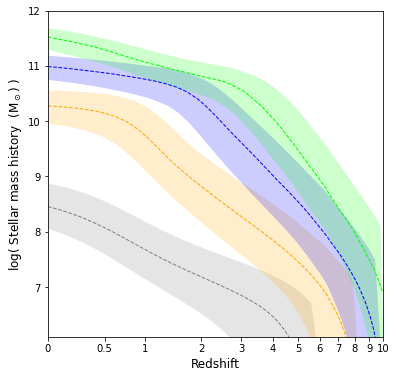

In [7]:
Mhalo_keys = ['Mhalo_11','Mhalo_12','Mhalo_13','Mhalo_14']

plot_fig18( Mhalo_keys ) ; plt.legend(); plt.show()
plot_fig18( Mhalo_keys, b18xscale=True ) ; plt.show()


## read Webb2022 results



In [8]:
# contains filenames of Prospector output
from Dragonfly44_SFH.fitting.output.fits_DF44_summary import *
path_fits = path_base+ "Dragonfly44_SFH/fitting/output/"

In [9]:
from Dragonfly44_SFH.utils.prospect_io import read_results

result_file1 = path_fits+ fit_aD1_phot_specKCWI
label1 = 'Extended SFH'
color1 = color_aD1

result_file2 = path_fits+ fit_aD02_phot_specKCWI
label2 = 'Concentrated SFH'
color2 = color_aD02

# ok that model fails to load, we dont need it here
result1, _, _ = read_results( result_file1 )
result2, _, _ = read_results( result_file2 )

# zobs = float(model1.params['zred'])

label0 = 'DF44:'

Error: failed to produce model
Error: failed to produce model


In [10]:
plot_params1 = dict( result=result1, label=label1, color=color1 )
plot_params2 = dict( result=result2, label=label2, color=color2 )


In [11]:
# convert agebins to redshift bins

from Dragonfly44_SFH.fitting.prospect.sources.constants import cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

agebins = np.copy( result1['agebins'] )
agebins_Gyr = np.power(10, agebins-9)

x_lb = np.unique( agebins_Gyr )
mx_lb = x_lb[:-1]+np.diff(x_lb)/2.
xlim_lb = [1e-2,14]

x_zred = np.full_like(x_lb, 0)
for i,x in enumerate(x_lb):
    try:
        x_zred[i] = z_at_value(cosmo.age, cosmo.age(zobs_DF44)-x * u.Gyr)
    except:
        pass


In [12]:
# calculate cumulative mass functions 

from Dragonfly44_SFH.utils.transforms import chain_to_sfr, chain_to_param
from prospect.plotting.sfh import sfh_to_cmf

for pp in [plot_params1,plot_params2]:
        
    # get posteriors for the sfr
    sfrs_post = chain_to_sfr( norm_by_mass=False, **pp['result'] )

    # covert to cmf
    x, cmfs_post = sfh_to_cmf( sfrs_post, agebins )
    
    logmass_post = chain_to_param( param='logmass', **pp['result'] )

    
    # reweight, if weights exist (i.e., used nested sampling)
    if 'weights' in pp['result'].keys():
        from dynesty.utils import resample_equal
        posts = np.hstack([ cmfs_post, logmass_post ])
        weights = np.copy( pp['result']['weights'] )
        posts = resample_equal( posts, weights)
        
        cmfs_post = posts[:,:-1]
        logmass_post = posts[:,-1]
    
    pp['cmf'] = cmfs_post
    pp['logmass'] = logmass_post
    
    csm = (cmfs_post.T * 10**logmass_post).T
    pp['csm'] = csm
    
    quantiles = [0.16,0.5,0.84]
    qs = np.array([ np.nanquantile( x, q=quantiles )
                                  for x in csm.T ]).T
    
    for i,q in enumerate( quantiles ):
        pp['csm_q{}'.format( '{:.0f}'.format(q*100) )] = qs[i,:]


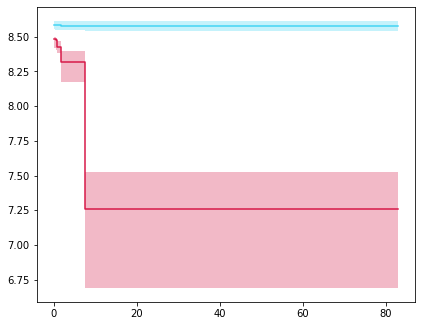

In [13]:
#
fig,ax = plt.subplots(1,1,figsize=(fig_width_one,fig_width_one*0.8))

for pp in [plot_params1,plot_params2]:
    
    x = x_zred
    y = np.log10( pp['csm_q50'] )
    
    ax.step( x, y, 
             color=pp['color'], lw=1.5, where='post', zorder=2)
    
    y1 = np.log10( pp['csm_q16'] )
    y2 = np.log10( pp['csm_q84'] )
    y1[-1] = y1[-2]
    y2[-1] = y2[-2]
    ax.fill_between(x, y1, y2, 
                    color=pp['color'], alpha=0.3, step='post', lw=0, zorder=1)

plt.show()

In [14]:
# get timescales, t50 and t90 (in units of cosmic time, ie. time since BB)
# also convert to redshifts

def get_tz_timescale( t ):
    try: 
        zt = z_at_value( cosmo.age, t*u.Gyr )
    except CosmologyError:
        # zt = cosmo.age(0).value
        zt = np.nan
    return zt

quantiles = [0.16,0.5,0.84]

for pp in [plot_params1,plot_params2]:
    
    cmf = pp['cmf']
    x = np.unique( agebins_Gyr )
    tuniv = cosmo.age(zobs_DF44).value

    N,M = np.shape(cmf)
    for t in [0.5,0.9]:
        str_t = 't{:.0f}'.format(t*100)
        str_z = 'z{:.0f}'.format(t*100)
        
        txs = np.full(N,np.nan)
        for ii in range(N):
            txs[ii] = np.interp( t, cmf[ii,::-1], x[::-1] )

        t_qs = np.quantile( txs, q=quantiles )
        z_qs = [ get_tz_timescale( tuniv-t ).value for t in t_qs ]
        
        for i,q in enumerate(quantiles):
            pp[str_t+'_'+'{:.0f}'.format(q*100)] = t_qs[i]
            pp[str_z+'_'+'{:.0f}'.format(q*100)] = z_qs[i]

        print( t_qs, z_qs )


[ 9.94295083 10.61849329 10.92278621] [1.8438732082379854, 2.2849515108556844, 2.5439662314445837]
[6.46610809 7.14824587 7.73989255] [0.7510445737138634, 0.8882650854483187, 1.0273187282881577]
[13.12843593 13.13170174 13.13271413] [12.065246830819598, 12.143588936987737, 12.168113947825848]
[12.85412188 12.86000034 12.86182264] [7.996945653135078, 8.052474512719662, 8.069862582891211]


## plot both

In [15]:
import matplotlib.patheffects as fx

In [16]:
Mhalo_keys = ['Mhalo_11','Mhalo_12','Mhalo_13']


2.2849515108556844
0.8882650854483187
12.143588936987737
8.052474512719662


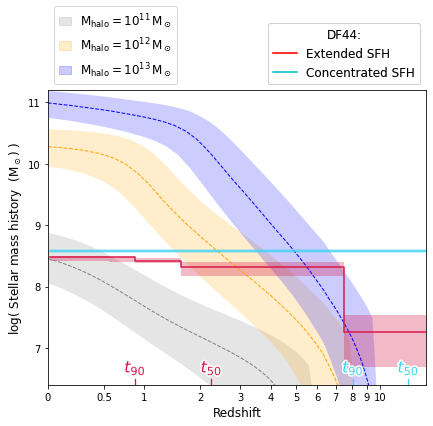

In [18]:
#
b18xscale = True

fig,ax = plt.subplots(1,1,figsize=(fig_width_one,fig_width_one*0.8))

ax = plot_fig18( Mhalo_keys, b18xscale=b18xscale, ax=ax, xlim=(0,10) )


for pp in [plot_params1,plot_params2]:

    x = x_zred
    if b18xscale: x = f_x_zred_to_pix( x_zred )
    y = np.log10( pp['csm_q50'] )
    
    ax.step( x, y, 
             color=pp['color'], lw=1.5, where='post', zorder=2)
    
    y1 = np.log10( pp['csm_q16'] )
    y2 = np.log10( pp['csm_q84'] )
    y1[-1] = y1[-2]
    y2[-1] = y2[-2]
    ax.fill_between(x, y1, y2, 
                    color=pp['color'], alpha=0.3, step='post', lw=0, zorder=1)

    ymin,ymax = 0,0.02
    for q in [50,90]:
        zq_50 = pp['z{}_50'.format(q)]
        print( zq_50 )
        
        if b18xscale: zq_50 = f_x_zred_to_pix( zq_50 )

        ax.axvline( zq_50, ymin,ymax,  
                    color=pp['color'], lw=1.3 )
        text = ax.text( zq_50,6.6, r'$t_{{{}}}$'.format(q), 
                        color=pp['color'], ha='center', fontsize=16 )

        text.set_path_effects([ fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal() ])
    

if True: # legend
    
    leg_params = alpha = dict(alpha=0.2)
    handles, labels = [],[]
    for Mhalo_key in Mhalo_keys:
        handles.append( ax.fill_between( [],[], color=dict_coords[Mhalo_key]['color'], **leg_params) )
        labels.append( dict_coords[Mhalo_key]['label'] )

    leg1 = ax.legend( handles, labels, loc=3, handlelength=1, bbox_to_anchor=[0,1] )
    
    leg_params = dict(lw=1.5)
    handles = [ ax.plot( [],[], color='r', **leg_params)[0],
                ax.plot( [],[], color='c', **leg_params)[0],
              ]
    labels = [ label1, label2 ]
    leg2 = ax.legend( handles, labels, loc=4, handlelength=2, bbox_to_anchor=[1,1], title=label0 )    
               

    ax.add_artist(leg1)
    ax.add_artist(leg2)
    
ax.set_ylim(6.4,11.2)
ax.set_xlim(None, f_x_zred_to_pix(tuniv) )

plt.savefig('figures/fig7.pdf', bbox_inches='tight', dpi=150)
plt.show()

Note: x-axis has been increased to show t50 for the aD02 fit correctly, rather than capped at z=10